# LoL Game Outcome Predictor

#### Things to consider:
1. winrates for each champ are the most recent winrates as of Sept 20, 2019 - this means game patches/updates that affect each champ are not considered
2. there are also winrates for each player, for each champ - these winrates could also be a better feature to use for predicting outcome
3. taking the point in time when an objective was taken into consideration would probably improve this model
4. rank of each player on each team may have an effect on outcome as well
5. taking the point in time of gold differential into account may also improve model
6. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval
import re

In [2]:
# https://www.leagueofgraphs.com/champions/counters/master

#### Loading all the data files

In [3]:
LOL = pd.read_csv('LeagueofLegends.csv')
matches = pd.read_csv('matchinfo.csv')
kills = pd.read_csv('kills.csv')
gold = pd.read_csv('gold.csv')
column_desc = pd.read_csv('_columns.csv')
monsters = pd.read_csv('monsters.csv')
structures = pd.read_csv('structures.csv')
bans = pd.read_csv('bans.csv')

In [4]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 50)

In [5]:
champs = [name for name in LOL.columns if 'Champ' in name]

In [6]:
list_of_dfs = [LOL, matches, kills, gold, monsters, structures, bans]

In [7]:
matches.head()

,League,Year,Season,Type,blueTeamTag,bResult,rResult,redTeamTag,gamelength,blueTop,blueTopChamp,blueJungle,blueJungleChamp,blueMiddle,blueMiddleChamp,blueADC,blueADCChamp,blueSupport,blueSupportChamp,redTop,redTopChamp,redJungle,redJungleChamp,redMiddle,redMiddleChamp,redADC,redADCChamp,redSupport,redSupportChamp,Address
0,NALCS,2015,Spring,Season,TSM,1,0,C9,40,Dyrus,Irelia,Santorin,RekSai,Bjergsen,Ahri,WildTurtle,Jinx,Lustboy,Janna,Balls,Gnar,Meteos,Elise,Hai,Fizz,Sneaky,Sivir,LemonNation,Thresh,http://matchhistory.na.leagueoflegends.com/en/...
1,NALCS,2015,Spring,Season,CST,0,1,DIG,38,Cris,Gnar,Impaler,Rengar,Jesiz,Ahri,Mash,Caitlyn,Sheep,Leona,Gamsu,Irelia,Crumbzz,JarvanIV,Shiphtur,Azir,CoreJJ,Corki,KiWiKiD,Annie,http://matchhistory.na.leagueoflegends.com/en/...
2,NALCS,2015,Spring,Season,WFX,1,0,GV,40,Flaresz,Renekton,ShorterACE,Rengar,Pobelter,Fizz,Altec,Sivir,Gleeb,Annie,Hauntzer,Sion,Saintvicious,LeeSin,Keane,Azir,Cop,Corki,BunnyFuFuu,Janna,http://matchhistory.na.leagueoflegends.com/en/...
3,NALCS,2015,Spring,Season,TIP,0,1,TL,41,Rhux,Irelia,Rush,JarvanIV,XiaoWeiXiao,Leblanc,Apollo,Sivir,Adrian,Thresh,Quas,Gnar,IWDominate,Nunu,Fenix,Lulu,KEITH,KogMaw,Xpecial,Janna,http://matchhistory.na.leagueoflegends.com/en/...
4,NALCS,2015,Spring,Season,CLG,1,0,T8,35,Benny,Gnar,Xmithie,JarvanIV,Link,Lissandra,Doublelift,Tristana,aphromoo,Janna,CaliTrlolz8,Sion,Porpoise8,RekSai,Slooshi8,Lulu,Maplestreet8,Corki,Dodo8,Annie,http://matchhistory.na.leagueoflegends.com/en/...


In [8]:
kills.head()

,Address,Team,Time,Victim,Killer,Assist_1,Assist_2,Assist_3,Assist_4,x_pos,y_pos
0,http://matchhistory.na.leagueoflegends.com/en/...,bKills,10.820,C9 Hai,TSM Bjergsen,NaN,NaN,NaN,NaN,9229,8469
1,http://matchhistory.na.leagueoflegends.com/en/...,bKills,16.286,C9 LemonNation,TSM WildTurtle,TSM Santorin,TSM Bjergsen,TSM Lustboy,NaN,13908,5960
2,http://matchhistory.na.leagueoflegends.com/en/...,bKills,18.733,C9 Hai,TSM Bjergsen,TSM Santorin,TSM WildTurtle,TSM Lustboy,NaN,8281,7889
3,http://matchhistory.na.leagueoflegends.com/en/...,bKills,18.880,C9 Meteos,TSM Dyrus,TSM Santorin,TSM Bjergsen,TSM WildTurtle,TSM Lustboy,8522,8895
4,http://matchhistory.na.leagueoflegends.com/en/...,bKills,27.005,C9 Balls,TSM Bjergsen,TSM Dyrus,TSM Santorin,TSM WildTurtle,TSM Lustboy,8902,7643


In [9]:
gold.head()

,Address,Type,min_1,min_2,min_3,min_4,min_5,min_6,min_7,min_8,min_9,min_10,min_11,min_12,min_13,min_14,min_15,min_16,min_17,min_18,min_19,min_20,min_21,min_22,min_23,min_24,min_25,min_26,min_27,min_28,min_29,min_30,min_31,min_32,min_33,min_34,min_35,min_36,min_37,min_38,min_39,min_40,min_41,min_42,min_43,min_44,min_45,min_46,min_47,min_48,min_49,min_50,min_51,min_52,min_53,min_54,min_55,min_56,min_57,min_58,min_59,min_60,min_61,min_62,min_63,min_64,min_65,min_66,min_67,min_68,min_69,min_70,min_71,min_72,min_73,min_74,min_75,min_76,min_77,min_78,min_79,min_80,min_81,min_82,min_83,min_84,min_85,min_86,min_87,min_88,min_89,min_90,min_91,min_92,min_93,min_94,min_95
0,http://matchhistory.na.leagueoflegends.com/en/...,golddiff,0,0,-14,-65,-268,-431,-488,-789,-494,-625,-1044,-313,-760,-697,-790,-611,240,845.0,797.0,1422.0,987.0,169.0,432.0,491.0,1205.0,1527.0,1647.0,1847.0,3750.0,4719.0,3561.0,3367.0,2886.0,2906.0,4411.0,4473.0,4639.0,4762.0,4686.0,6057.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,http://matchhistory.na.leagueoflegends.com/en/...,golddiff,0,0,-26,-18,147,237,-152,18,88,-242,102,117,802,1420,1394,1301,1489,1563.0,1368.0,1105.0,205.0,192.0,587.0,377.0,667.0,415.0,1876.0,1244.0,2130.0,2431.0,680.0,1520.0,949.0,1894.0,2644.0,3394.0,3726.0,1165.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,http://matchhistory.na.leagueoflegends.com/en/...,golddiff,0,0,10,-60,34,37,589,1064,1258,913,1233,1597,1575,3046,2922,3074,3626,3466.0,5634.0,5293.0,4597.0,4360.0,4616.0,4489.0,4880.0,5865.0,6993.0,7049.0,7029.0,7047.0,7160.0,7081.0,7582.0,9917.0,10337.0,9823.0,12307.0,13201.0,13924.0,13915.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,http://matchhistory.na.leagueoflegends.com/en/...,golddiff,0,0,-15,25,228,-6,-243,175,-346,16,-258,-57,-190,-111,-335,-8,324,428.0,-124.0,768.0,2712.0,1813.0,198.0,1242.0,1245.0,1278.0,1240.0,-664.0,-1195.0,-1157.0,-2161.0,-2504.0,-3873.0,-3688.0,-3801.0,-3668.0,-3612.0,-5071.0,-2825.0,-1464.0,-4507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,http://matchhistory.na.leagueoflegends.com/en/...,golddiff,40,40,44,-36,113,158,-121,-191,23,205,156,272,-271,-896,-574,177,-425,-730.0,-318.0,478.0,926.0,761.0,-286.0,473.0,490.0,1265.0,2526.0,3890.0,4319.0,5121.0,5140.0,5141.0,6866.0,9517.0,11322.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
monsters.head()

,Address,Team,Time,Type
0,http://matchhistory.na.leagueoflegends.com/en/...,bDragons,37.267,DRAGON
1,http://matchhistory.na.leagueoflegends.com/en/...,bDragons,32.545,DRAGON
2,http://matchhistory.na.leagueoflegends.com/en/...,bDragons,26.177,DRAGON
3,http://matchhistory.na.leagueoflegends.com/en/...,bDragons,19.119,DRAGON
4,http://matchhistory.na.leagueoflegends.com/en/...,bDragons,24.577,DRAGON


In [11]:
structures.head()

,Address,Team,Time,Lane,Type
0,http://matchhistory.na.leagueoflegends.com/en/...,bTowers,27.542,MID_LANE,BASE_TURRET
1,http://matchhistory.na.leagueoflegends.com/en/...,bTowers,39.269,MID_LANE,NEXUS_TURRET
2,http://matchhistory.na.leagueoflegends.com/en/...,bTowers,33.583,BOT_LANE,INNER_TURRET
3,http://matchhistory.na.leagueoflegends.com/en/...,bTowers,23.038,TOP_LANE,INNER_TURRET
4,http://matchhistory.na.leagueoflegends.com/en/...,bTowers,16.556,BOT_LANE,OUTER_TURRET


#### Check out which team wins more

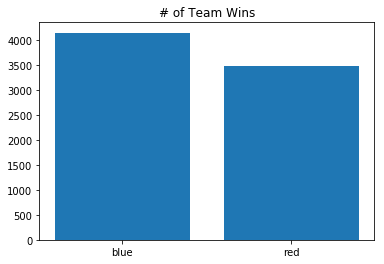

In [12]:
plt.bar(x=['blue','red'], height=[LOL.bResult.sum(),LOL.rResult.sum()])
plt.title('# of Team Wins')
plt.show()

#### LOL dataframe has all lists in string format, so changing them all to lists

In [13]:
# only run once
LOL.golddiff = [literal_eval(array) for array in LOL.golddiff]
LOL.bKills = [literal_eval(array) for array in LOL.bKills]

#### Seeing picks for a certain season (Spring 2015)

In [14]:
spr2015 = LOL.query('Year == 2015')[LOL.Season == 'Spring']

/Users/paulyun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


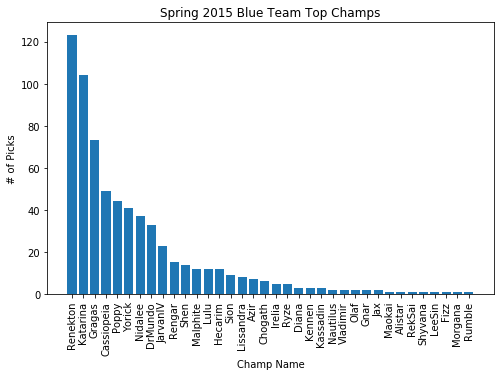

In [15]:
# all champs picked for top lane by blue team for Spring 2015
plt.figure(figsize=(8,5))
plt.title('Spring 2015 Blue Team Top Champs')
plt.xlabel('Champ Name')
plt.ylabel('# of Picks')
plt.xticks(rotation='vertical')
plt.bar(list(set(spr2015.blueTopChamp)),spr2015.blueTopChamp.value_counts())
plt.show()

In [16]:
# winrates are current winrates for each champ, so this will be inaccurate for past games
winrates = pd.read_csv('winrates.csv')

In [17]:
winrates = winrates.sort_values(by='Winrate')

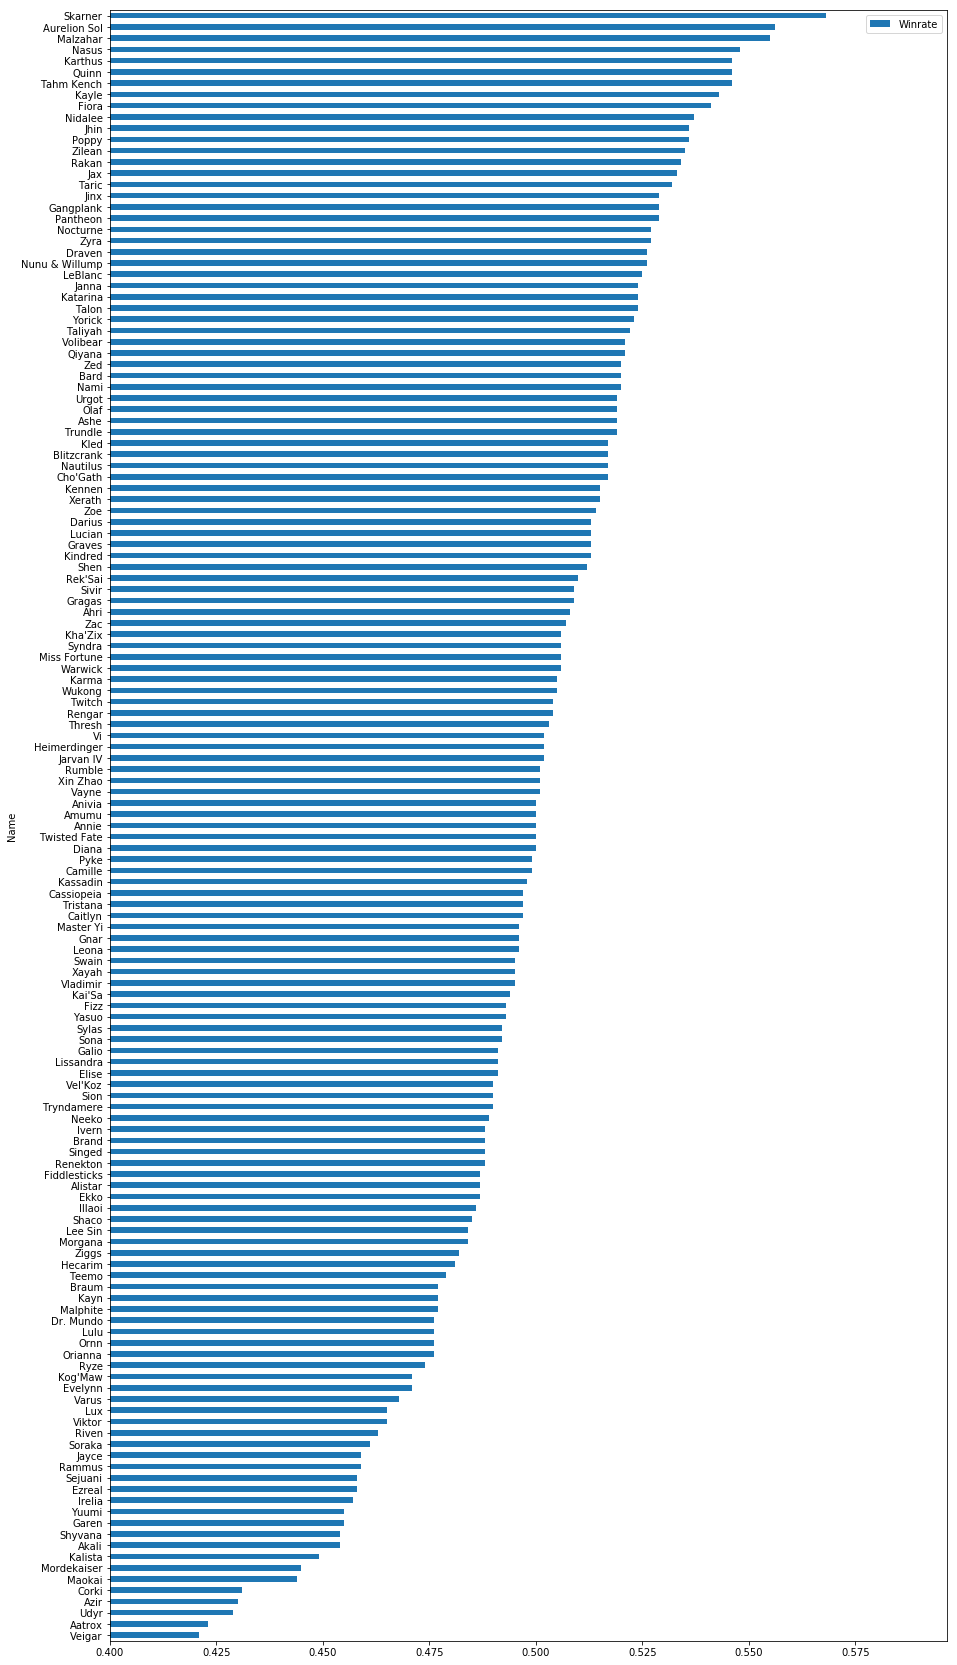

In [18]:
winrates.plot.barh(x='Name',y='Winrate', figsize=(15,30), xlim=(.4))

In [19]:
def create_gameID(df):
    ids = []
    try:
        for i in range(len(df.Address)):
            if '=' not in df.Address[i]:
                ids.append(df.Address[i][df.Address[i].index('JP1')+3:-1])
            else:
                ids.append(df.Address[i][df.Address[i].index('Hash=')+5:-1])
        df['gameID'] = ids
    except:
        None
    return df

In [ ]:
for df in list_of_dfs:
    create_gameID(df)

In [ ]:
for df in list_of_dfs:
    df = df.drop('Address', axis=1, inplace=True)

### Start creating a final db
Make other table data usable and merge to matches df

#### Make kills data easier to use (no time-series)

In [ ]:
column_desc.ColumnDescription[12]

In [ ]:
bkills = kills[kills.Team == 'bKills']
countbkills = bkills.fillna(0).groupby('gameID').count()

In [ ]:
rkills = kills[kills.Team == 'rKills']
countrkills = rkills.fillna(0).groupby('gameID').count()

In [ ]:
countbkills['totassists'] = countbkills.Assist_1 + countbkills.Assist_2 + countbkills.Assist_3 + countbkills.Assist_4
countrkills['totassists'] = countrkills.Assist_1 + countrkills.Assist_2 + countrkills.Assist_3 + countrkills.Assist_4


add these to a final df

In [21]:
final = matches.merge(bkills.groupby('gameID')[['Killer']].count(), on='gameID', how='left').rename(columns={'Killer':'bkills'})

In [22]:
final = final.merge(countbkills[['totassists']], on='gameID').rename(columns={'totassists':'b_assists'})

In [23]:
final = final.merge(countrkills[['Killer']], on='gameID').rename(columns={'Killer':'rkills'})

In [24]:
final = final.merge(countrkills[['totassists']], on='gameID').rename(columns={'totassists':'r_assists'})

#### Make monsters data easier to use

In [25]:
set(monsters.Team)

{'bBarons', 'bDragons', 'bHeralds', 'rBarons', 'rDragons', 'rHeralds'}

In [26]:
bdrags = monsters.groupby(['gameID','Team']).count()[['Type']].xs('bDragons', level='Team').rename(columns={'Type':'bdragons'})
bbars = monsters.groupby(['gameID','Team']).count()[['Type']].xs('bBarons', level='Team').rename(columns={'Type':'bbarons'})
bhers = monsters.groupby(['gameID','Team']).count()[['Type']].xs('bHeralds', level='Team').rename(columns={'Type':'bheralds'})


In [27]:
rdrags = monsters.groupby(['gameID','Team']).count()[['Type']].xs('rDragons', level='Team').rename(columns={'Type':'rdragons'})
rbars = monsters.groupby(['gameID','Team']).count()[['Type']].xs('rBarons', level='Team').rename(columns={'Type':'rbarons'})
rhers = monsters.groupby(['gameID','Team']).count()[['Type']].xs('rHeralds', level='Team').rename(columns={'Type':'rheralds'})


add to final df

In [28]:
final = final.merge(bdrags, on='gameID',how='left').merge(bbars, on='gameID',how='left').merge(bhers, on='gameID',how='left')
final = final.merge(rdrags, on='gameID',how='left').merge(rbars, on='gameID',how='left').merge(rhers, on='gameID',how='left')

#### Make gold data easier to use
Domain knowledge: gold differential is very important in any matchup <br>
Gold amounts for each position is very player specific, and may not really be good features to include

In [29]:
column_desc.ColumnDescription[10]

' Gold difference - computed Blue minus Red - by minute \n'

In [30]:
groupedgold = gold[gold['Type'] == 'golddiff'].groupby('gameID').sum()

In [31]:
groupedgold['avggolddiff'] = groupedgold.mean(axis=1)

In [32]:
# half-time gold and end-time gold

add to final df

In [33]:
final = final.merge(groupedgold[['avggolddiff']], on='gameID', how='left')

#### Make structures data easier to use

In [34]:
structures['struct'] = structures.Lane + structures.Type

In [35]:
grpstruct = structures.groupby(['gameID','Team'])[['struct']].count()

In [36]:
set(structures.Team)

{'bInhibs', 'bTowers', 'rInhibs', 'rTowers'}

In [37]:
# structures TAKEN by blue team
binhibs = grpstruct.xs('bInhibs', level='Team').rename(columns={'struct':'binhibs'})
btowers = grpstruct.xs('bTowers', level='Team').rename(columns={'struct':'btowers'})

# structures TAKEN by red team
rinhibs = grpstruct.xs('rInhibs', level='Team').rename(columns={'struct':'rinhibs'})
rtowers = grpstruct.xs('rTowers', level='Team').rename(columns={'struct':'rtowers'})

In [38]:
final = final.merge(binhibs, on='gameID', how='left').merge(btowers, on='gameID', how='left').merge(rinhibs, on='gameID', how='left').merge(rtowers, on='gameID', how='left')


#### Make winrates easier to use
Instead of using winrates file, calculated my own winrates using the data in dataset

In [39]:
dict(zip(winrates.Name, winrates.Winrate))

{'Veigar': 0.42100000000000004,
 'Aatrox': 0.423,
 'Udyr': 0.429,
 'Azir': 0.43,
 'Corki': 0.431,
 'Maokai': 0.444,
 'Mordekaiser': 0.445,
 'Kalista': 0.449,
 'Akali': 0.45399999999999996,
 'Shyvana': 0.45399999999999996,
 'Garen': 0.455,
 'Yuumi': 0.455,
 'Irelia': 0.457,
 'Ezreal': 0.45799999999999996,
 'Sejuani': 0.45799999999999996,
 'Rammus': 0.45899999999999996,
 'Jayce': 0.45899999999999996,
 'Soraka': 0.461,
 'Riven': 0.46299999999999997,
 'Viktor': 0.465,
 'Lux': 0.465,
 'Varus': 0.46799999999999997,
 'Evelynn': 0.47100000000000003,
 "Kog'Maw": 0.47100000000000003,
 'Ryze': 0.474,
 'Orianna': 0.47600000000000003,
 'Ornn': 0.47600000000000003,
 'Lulu': 0.47600000000000003,
 'Dr. Mundo': 0.47600000000000003,
 'Malphite': 0.47700000000000004,
 'Kayn': 0.47700000000000004,
 'Braum': 0.47700000000000004,
 'Teemo': 0.479,
 'Hecarim': 0.48100000000000004,
 'Ziggs': 0.48200000000000004,
 'Morgana': 0.484,
 'Lee Sin': 0.484,
 'Shaco': 0.485,
 'Illaoi': 0.486,
 'Ekko': 0.487000000000000

In [40]:
bTopWR = matches[['blueTopChamp','bResult']].groupby('blueTopChamp').sum()
bTopWR['topwinrate'] = bTopWR.bResult/sum(bTopWR.bResult)

In [41]:
bJGWR = matches[['blueJungleChamp','bResult']].groupby('blueJungleChamp').sum()
bJGWR['jgwinrate'] = bJGWR.bResult/sum(bJGWR.bResult)

In [42]:
bMidWR = matches[['blueMiddleChamp','bResult']].groupby('blueMiddleChamp').sum()
bMidWR['midwinrate'] = bMidWR.bResult/sum(bMidWR.bResult)

In [43]:
bADCWR = matches[['blueADCChamp','bResult']].groupby('blueADCChamp').sum()
bADCWR['adcwinrate'] = bADCWR.bResult/sum(bADCWR.bResult)

In [44]:
bSupWR = matches[['blueSupportChamp','bResult']].groupby('blueSupportChamp').sum()
bSupWR['supwinrate'] = bSupWR.bResult/sum(bSupWR.bResult)

In [45]:
WR = bTopWR.merge(bJGWR, how='outer', left_index=True, right_index=True, suffixes=('_top','_jg'))

WR = WR.merge(bMidWR, how='outer', left_index=True, right_index=True)

WR = WR.merge(bADCWR, how='outer', left_index=True, right_index=True, suffixes=('_mid','_adc'))

WR = WR.merge(bSupWR, how='outer', left_index=True, right_index=True).rename(columns={'bResult':'bResult_sup'})

WR = WR.fillna(0)

In [46]:
WR['totwins'] = WR.bResult_top + WR.bResult_jg + WR.bResult_mid + WR.bResult_adc + WR.bResult_sup

WR['avgwinrate'] = WR.totwins/sum(WR.totwins)

In [47]:
WR = WR.drop(['bResult_top','bResult_jg','bResult_mid','bResult_adc','bResult_sup','topwinrate', 'jgwinrate','midwinrate','adcwinrate','supwinrate'],axis=1)

#### Make each champ a dummy variable

In [48]:
all_champs = []
for col in champs:
    all_champs.extend(list(matches[f'{col}'].unique()))

In [49]:
dummies = []

for idx, row in matches[champs].iterrows():
    new = {}
    for champ in all_champs:
        new[champ] = 0
    for played in row:
        if played in all_champs:
            new[played] += 1
        else:
            continue
    dummies.append(new)

In [50]:
champsdf = pd.DataFrame(dummies)

In [51]:
champsdf.rename(columns={'MonkeyKing':'Wukong'},inplace=True)

add to final df

In [52]:
final = pd.concat([final,champsdf], axis=1)

# Remove some features

In [53]:
cols_to_drop = list(final.columns[:29])

In [54]:
cols_to_drop.remove('bResult')

In [55]:
final = final.drop(cols_to_drop, axis=1)

In [56]:
final.fillna(0,inplace=True)

More EDA for further feature selection

In [57]:
import seaborn as sns

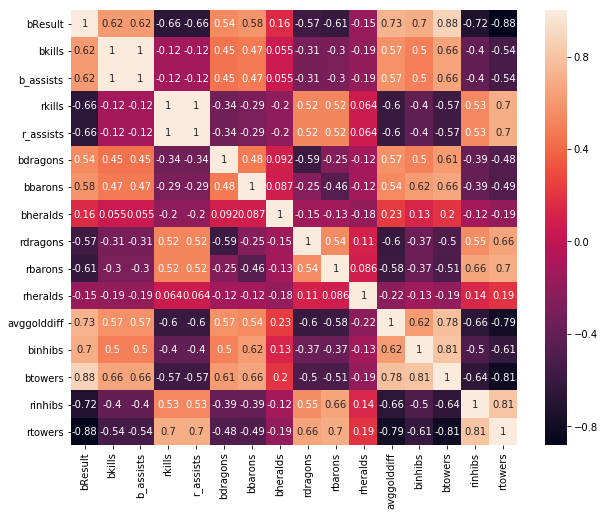

In [58]:
fig1, ax1 = plt.subplots(figsize=(10,8))

sns.heatmap(final[final.columns[:17]].corr(), annot=True)

In [59]:
# get rid of 'btowers' feature

final2 = final.drop(['btowers'],axis=1)

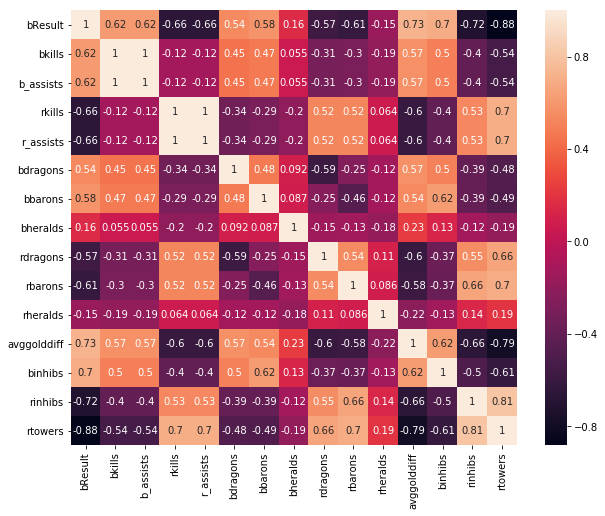

In [60]:
fig1, ax2 = plt.subplots(figsize=(10,8))

sns.heatmap(final2[final2.columns[:16]].corr(),annot=True)

In [61]:
# getting rid of highly correlated features
final3 = final2.drop(['b_assists', 'r_assists', 'rtowers'],axis=1)

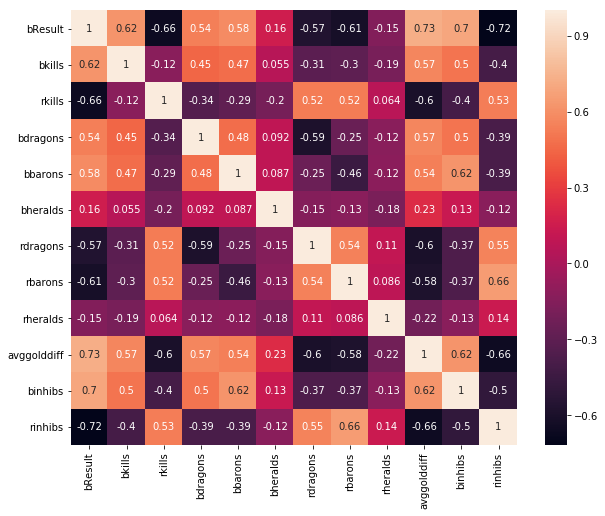

In [62]:
fig1, ax2 = plt.subplots(figsize=(10,8))

sns.heatmap(final3[final3.columns[:13]].corr(),annot=True)

After running Random Forest Classifier on final3, found that binhibs was the most important feature for predicting wins/losses. Decided to remove binhibs.

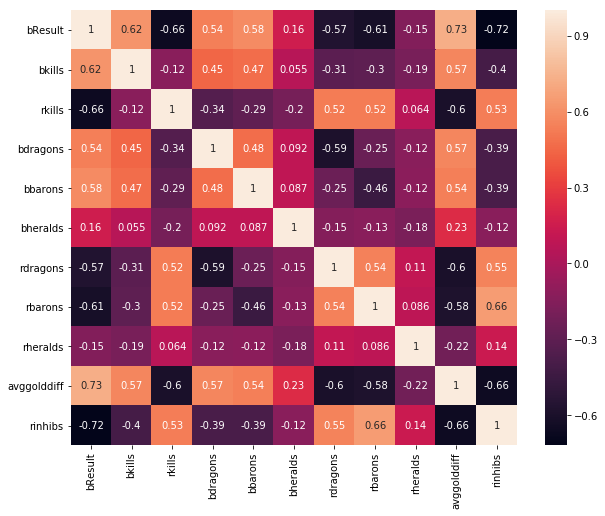

In [133]:
# getting rid of highly predictive features
final4 = final3.drop('binhibs',axis=1)

fig1, ax2 = plt.subplots(figsize=(10,8))

sns.heatmap(final4[final4.columns[:12]].corr(),annot=True)

In [64]:
features = final.columns[2:]

In [65]:
X = final.loc[:,features]
y = final.loc[:,'bResult']

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

update data without 'btowers' feature

In [67]:
features2 = final2.columns[2:]

X1 = final.loc[:,features2]

In [68]:
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.3,random_state=42)

update data without 'rtowers', 'b_assists', 'r_assists'

In [69]:
features3 = final3.columns[2:]

X2 = final3.loc[:,features3]

In [70]:
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.3,random_state=42)

update data without 'binihbs'

In [137]:
features4 = final4.columns[2:]

X3 = final4.loc[:,features4]

In [138]:
X3_train, X3_test, y_train, y_test = train_test_split(X3, y, test_size=0.3,random_state=42)

# Flaunt what ya mama gave ya
(Modelling)

In [63]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier

### Random Forest
##### First random forest

In [71]:
forest_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1,2,5,10,15,20],
    'n_estimators': [1,2,3,4,5,10,15],
    'n_jobs': [-1]
}

In [72]:
grid_search_forest1 = GridSearchCV(RandomForestClassifier(), forest_params, cv=3)
grid_search_forest1.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 5, 10, 15, 20], 'n_estimators': [1, 2, 3, 4, 5, 10, 15], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [73]:
grid_search_forest1.best_params_

{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 15, 'n_jobs': -1}

In [74]:
forest1 = RandomForestClassifier(n_estimators=15, max_depth=15, criterion='entropy', n_jobs=-1)

In [75]:
forest1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [76]:
forest1.score(X_train, y_train)

0.9990626171728534

In [77]:
forest1.fit(X_test, y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [78]:
forest1.score(X_test, y_test)

1.0

In [79]:
forest1_preds = forest1.predict(X_test)

In [80]:
pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=forest1_preds))

,0,1
0,1032,0
1,0,1254


##### Random forest without btowers

In [81]:
grid_search_forest2 = GridSearchCV(RandomForestClassifier(), forest_params, cv=3)
grid_search_forest2.fit(X1_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 5, 10, 15, 20], 'n_estimators': [1, 2, 3, 4, 5, 10, 15], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [82]:
grid_search_forest2.best_params_

{'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 15, 'n_jobs': -1}

In [83]:
forest2 = RandomForestClassifier(criterion= 'entropy', max_depth= 15, n_estimators= 10, n_jobs= -1)

forest2.fit(X1_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [84]:
forest2.score(X1_train, y_train)

0.9983127109111362

In [85]:
forest2.fit(X1_test, y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [86]:
forest2.score(X1_test, y_test)

0.9991251093613298

In [87]:
forest2_preds = forest2.predict(X1_test)

pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=forest2_preds))

,0,1
0,1032,0
1,2,1252


##### Random forest 3

In [88]:
grid_search_forest3 = GridSearchCV(RandomForestClassifier(), forest_params, cv=3)
grid_search_forest3.fit(X2_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 5, 10, 15, 20], 'n_estimators': [1, 2, 3, 4, 5, 10, 15], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [89]:
# best parameters
grid_search_forest3.best_params_

{'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 15, 'n_jobs': -1}

In [116]:
forest3 = RandomForestClassifier(criterion='gini', max_depth=15, n_estimators=15, n_jobs=-1)
forest3.fit(X2_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [92]:
forest3.score(X2_train, y_train)

0.9975628046494188

In [93]:
forest3.fit(X2_test, y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [94]:
forest3.score(X2_test, y_test)

0.9986876640419947

In [95]:
forest3_preds = forest3.predict(X2_test)

pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=forest3_preds))

,0,1
0,1032,0
1,3,1251


In [96]:
forest3_ft_imp = pd.DataFrame(dict(zip(list(final3.columns[2:]), list(forest3.feature_importances_))),index=range(1))

forest3_ft_imp = forest3_ft_imp[forest3_ft_imp>.02].dropna(axis=1).T

forest3_ft_imp.columns = ['Feature_Weight']

In [97]:
forest3_ft_imp.sort_values(by='Feature_Weight', ascending=False)

,Feature_Weight
binhibs,0.206582
avggolddiff,0.147228
rinhibs,0.143340
bkills,0.086771
rkills,0.067607
bdragons,0.067320
rbarons,0.065312
bbarons,0.062160
rdragons,0.041617


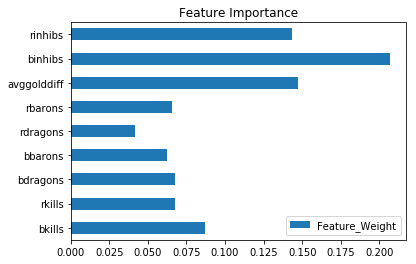

In [98]:
forest3_ft_imp.plot.barh(title='Feature Importance')

### Bagging?

In [99]:
bagging_params = {
    'bootstrap': [True, False],
    'max_features': [1,2,5,10,15,20],
    'n_estimators': [1,2,3,4,5,10,15],
    'n_jobs': [-1],
    'max_samples': [1,2,3,4,5,10,15]
}

In [101]:
grid_search_bagging = GridSearchCV(BaggingClassifier(), bagging_params, cv=3)
grid_search_bagging.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'bootstrap': [True, False], 'max_features': [1, 2, 5, 10, 15, 20], 'n_estimators': [1, 2, 3, 4, 5, 10, 15], 'n_jobs': [-1], 'max_samples': [1, 2, 3, 4, 5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [102]:
grid_search_bagging.best_params_

{'bootstrap': False,
 'max_features': 20,
 'max_samples': 10,
 'n_estimators': 10,
 'n_jobs': -1}

In [103]:
baggage1 = BaggingClassifier(bootstrap=True, max_features=20, max_samples=15, n_estimators=15, n_jobs=-1)

In [104]:
baggage1.fit(X_train, y_train)

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=20, max_samples=15,
         n_estimators=15, n_jobs=-1, oob_score=False, random_state=None,
         verbose=0, warm_start=False)

In [105]:
baggage1.score(X_train, y_train)

0.9615673040869891

In [106]:
baggage1.fit(X_test, y_test)

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=20, max_samples=15,
         n_estimators=15, n_jobs=-1, oob_score=False, random_state=None,
         verbose=0, warm_start=False)

In [107]:
baggage1.score(X_test, y_test)

0.9453193350831146

In [108]:
baggage1_preds = baggage1.predict(X_test)

In [109]:
pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=baggage1_preds))

,0,1
0,984,48
1,77,1177


### OMG, I'm so BOOSTED!
(XG Boost)

In [110]:
import xgboost as xgb
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [117]:
clf = xgb.XGBClassifier()
booster = clf.fit(np.array(X_train), np.array(y_train))
training_preds = clf.predict(np.array(X_train))
val_preds = clf.predict(np.array(X_test))
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Training Accuracy: 99.63%
Validation accuracy: 98.16%


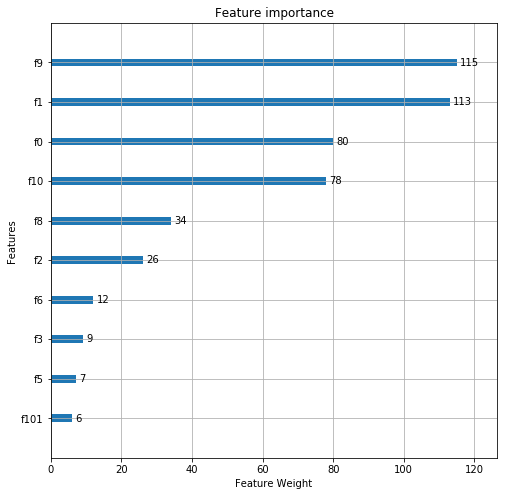

In [118]:
fig, ax = plt.subplots(figsize=(8,8))
n_features = X2_train.shape[1]
xgb.plot_importance(clf.fit(np.array(X2_train), np.array(y_train)), ax=ax, xlabel='Feature Weight', max_num_features=10)
plt.show()

In [114]:
features3[9], features3[1], features3[0], features3[10], features3[8], features3[2], features3[6], features3[3], features3[5], features3[101]

('binhibs',
 'rkills',
 'bkills',
 'rinhibs',
 'avggolddiff',
 'bdragons',
 'rbarons',
 'bbarons',
 'rdragons',
 'Renekton')

In [113]:
param_grid = {
    "learning_rate": [0.1],
    'max_depth': [6],
    'min_child_weight': [10],
    'subsample': [ 0.7],
    'n_estimators': [5, 30, 100, 250],
}

### Trying Support Vector Machine (SVM) with Principal Component Analysis (PCA)

In [134]:
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

##### Normalize data for PCA

In [144]:
normalized_df = pd.DataFrame(data=StandardScaler().fit_transform(X3), columns=X3.columns)

/Users/paulyun/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/paulyun/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [145]:
normalized_df.cov()

,bkills,rkills,bdragons,bbarons,bheralds,rdragons,rbarons,rheralds,avggolddiff,rinhibs,Aatrox,Ahri,Akali,Alistar,Amumu,Anivia,Annie,Ashe,AurelionSol,Azir,Bard,Blitzcrank,Brand,Braum,Caitlyn,Camille,Cassiopeia,Chogath,Corki,Darius,Diana,DrMundo,Draven,Ekko,Elise,Evelynn,Ezreal,FiddleSticks,Fiddlesticks,Fiora,Fizz,Galio,Gangplank,Garen,Gnar,Gragas,Graves,Hecarim,Heimerdinger,Illaoi,Irelia,Ivern,Janna,JarvanIV,Jax,Jayce,Jhin,Jinx,Kalista,Karma,Karthus,Kassadin,Katarina,Kayle,Kayn,Kennen,Khazix,Kindred,Kled,KogMaw,Leblanc,LeeSin,Leona,Lissandra,Lucian,Lulu,Lux,Malphite,Malzahar,Maokai,MasterYi,MissFortune,Wukong,Mordekaiser,Morgana,Nami,Nasus,Nautilus,Nidalee,Nocturne,Nunu,Olaf,Orianna,Ornn,Pantheon,Poppy,Quinn,Rakan,Rammus,RekSai,Renekton,Rengar,Riven,Rumble,Ryze,Sejuani,Shaco,Shen,Shyvana,Singed,Sion,Sivir,Skarner,Sona,Soraka,Swain,Syndra,TahmKench,Taliyah,Talon,Taric,Teemo,Thresh,Tristana,Trundle,Tryndamere,TwistedFate,Twitch,Udyr,Urgot,Varus,Vayne,Veigar,Velkoz,Vi,Viktor,Vladimir,Volibear,Warwick,Xayah,Xerath,XinZhao,Yasuo,Yorick,Zac,Zed,Ziggs,Zilean,Zoe,Zyra
bkills,1.000131,-0.121840,0.446921,0.474032,0.054712,-0.313484,-0.296288,-0.190201,0.568237,-0.404089,0.041413,0.050039,0.015255,-0.017830,0.029891,-0.012527,0.075506,0.011175,0.008052,-0.032436,-0.011146,0.035800,0.024650,-0.067583,-0.020606,0.019881,-0.010780,-0.008296,-0.003255,0.018248,0.020266,0.013291,-0.005022,0.000656,-0.041664,0.017378,-0.016202,0.015801,0.032123,-0.016529,0.044946,-0.029874,-0.018412,0.014604,-0.015487,-0.011413,-0.015154,0.031464,0.087523,-0.014651,0.010897,-0.023189,-0.017119,0.011426,-0.021378,0.019804,0.038005,0.014305,-0.001085,-0.060442,0.020782,0.010498,0.019440,-0.003294,0.001285,0.001920,0.028839,-0.033350,0.008254,-0.028526,-0.000848,0.047765,0.050684,0.038278,-0.028167,-0.044150,-0.009722,-0.005914,0.045611,0.009211,0.025993,0.039903,0.051980,0.020424,0.027190,-0.009096,-0.023036,0.002824,-0.035088,0.051034,0.016322,0.010968,-0.011616,-0.028112,0.036867,-0.017968,-0.007729,-0.020760,-0.013649,0.001843,0.012713,0.047897,0.006790,0.083728,-0.019215,-0.011942,0.017729,-0.027695,0.000057,0.015867,0.026094,-0.011300,0.009326,-0.000246,-0.008555,-0.011268,-0.006407,-0.028249,0.039547,0.050756,-0.027742,0.057795,0.046309,-0.054256,-0.059973,-0.008296,0.019798,0.007584,0.010339,0.038338,0.008371,0.017462,0.013805,0.017943,0.032519,-0.028367,-0.010360,0.018116,0.014764,-0.036614,0.019558,-0.005140,0.043680,0.015447,0.006865,0.046825,0.011175,-0.013768,-0.003673,0.028043
rkills,-0.121840,1.000131,-0.339558,-0.294821,-0.199846,0.524034,0.523871,0.064488,-0.599955,0.534836,0.015829,0.057342,0.012166,-0.027642,0.029317,-0.025595,0.048148,0.000390,0.014020,-0.026822,0.014657,0.031004,0.021211,-0.052064,-0.041985,-0.017384,0.012261,-0.042042,-0.004711,0.013470,0.030009,-0.000958,0.004516,0.008422,-0.008217,0.032255,-0.011157,-0.000387,0.004586,0.002009,0.029729,-0.037926,-0.022159,0.044330,-0.010499,-0.008204,-0.003978,0.037165,0.021181,0.000153,0.040998,0.008015,-0.011748,0.000578,-0.007352,0.012422,0.045851,0.027915,-0.008013,-0.038455,0.036136,0.010676,0.043659,0.005313,0.003046,-0.001190,-0.015154,-0.025232,-0.001290,-0.022183,0.031019,0.029814,0.047743,0.051273,0.001117,-0.040760,-0.023810,-0.009910,0.037971,0.008036,-0.015239,0.028963,0.025400,-0.018058,0.019626,0.016895,0.006316,0.032441,-0.040120,0.016255,0.020412,0.022391,-0.022761,-0.042440,0.055368,-0.031477,0.010019,-0.028452,0.004997,0.020417,-0.007874,0.005312,0.012816,0.039062,-0.031053,-0.016247,0.023186,-0.014799,-0.017361,0.019481,0.033091,0.014103,-0.018452,-0.002863,-0.011877,-0.008063,-0.003405,-0.039827,-0.011913,0.014764,-0.053044,0.025816,0.056409,-0.058500,-0.036842,0.007833,0.033709,0.019354,-0.008517,0.037441,-0.009551,0.007137,-0.011660,0.005012,0.019924,-0.001637,-0.005565,-0.006224,0.029511,-0.038923,0.008842,0.000800,0.017679,0.023313,-0.033300,0.047054,-0.001105,-0.014005,-0.041452,0.030525
bdragons,0.446921,-0.339558,1.000131,0.475083,0.092067,-0.586442,-0.252243,-0.